<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[-1.05128703,  0.01554239, -0.64140833,  0.27699756, -0.24763715,
         2.37111303],
       [-0.74665267, -1.01171112, -0.60721525, -0.22914135,  0.54151162,
         1.43790083],
       [-0.18643914, -1.26933713,  0.19545652, -1.17440874,  2.71319623,
        -0.08350282],
       [-0.56338757, -1.50767677, -0.35336553, -1.44420747,  1.09068317,
         0.52682524],
       [ 2.62863928,  0.22564029,  1.37753634,  1.32887233,  1.53445736,
         0.0322072 ],
       [-1.06422019,  1.05141279,  2.43941589, -0.10264722,  1.10356414,
        -0.89270806],
       [ 0.41045679, -1.24992914,  1.62610847, -0.70541605, -1.19273281,
         1.06151554],
       [ 0.24896308,  0.17410867, -1.55846166,  0.83633578, -0.01974861,
        -0.78165962]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.040491,-0.446494,0.309758,-0.151702,0.690412,0.458961
std,1.211523,0.930612,1.367844,0.954957,1.200455,1.122806
min,-1.064220,-1.507677,-1.558462,-1.444207,-1.192733,-0.892708
25%,-0.822811,-1.254781,-0.615764,-0.822664,-0.076721,-0.258042
50%,-0.374913,-0.498084,-0.078955,-0.165894,0.816097,0.279516
75%,0.289337,0.186992,1.439679,0.416832,1.211287,1.155612
max,2.628639,1.051413,2.439416,1.328872,2.713196,2.371113


In [16]:
df

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-1.051287,-0.746653,-0.186439,-0.563388,2.628639,-1.064220,0.410457,0.248963
B,0.015542,-1.011711,-1.269337,-1.507677,0.225640,1.051413,-1.249929,0.174109
C,-0.641408,-0.607215,0.195457,-0.353366,1.377536,2.439416,1.626108,-1.558462
D,0.276998,-0.229141,-1.174409,-1.444207,1.328872,-0.102647,-0.705416,0.836336
E,-0.247637,0.541512,2.713196,1.090683,1.534457,1.103564,-1.192733,-0.019749
F,2.371113,1.437901,-0.083503,0.526825,0.032207,-0.892708,1.061516,-0.781660


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,2.371113,-0.247637,0.276998,-0.641408,0.015542,-1.051287
2023-01-02,1.437901,0.541512,-0.229141,-0.607215,-1.011711,-0.746653
2023-01-03,-0.083503,2.713196,-1.174409,0.195457,-1.269337,-0.186439
2023-01-04,0.526825,1.090683,-1.444207,-0.353366,-1.507677,-0.563388
2023-01-05,0.032207,1.534457,1.328872,1.377536,0.225640,2.628639
2023-01-06,-0.892708,1.103564,-0.102647,2.439416,1.051413,-1.064220
2023-01-07,1.061516,-1.192733,-0.705416,1.626108,-1.249929,0.410457
2023-01-08,-0.781660,-0.019749,0.836336,-1.558462,0.174109,0.248963


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708


In [20]:
df

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -1.051287
2023-01-02   -0.746653
2023-01-03   -0.186439
2023-01-04   -0.563388
2023-01-05    2.628639
2023-01-06   -1.064220
2023-01-07    0.410457
2023-01-08    0.248963
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


##Selection by label

In [25]:
df.loc[dates[1]]

A   -0.746653
B   -1.011711
C   -0.607215
D   -0.229141
E    0.541512
F    1.437901
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-1.051287,0.276998
2023-01-02,-0.746653,-0.229141
2023-01-03,-0.186439,-1.174409
2023-01-04,-0.563388,-1.444207
2023-01-05,2.628639,1.328872
2023-01-06,-1.064220,-0.102647
2023-01-07,0.410457,-0.705416
2023-01-08,0.248963,0.836336


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-0.563388,-1.444207
2023-01-05,2.628639,1.328872
2023-01-06,-1.064220,-0.102647


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -0.563388
D   -1.444207
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

-0.22914135040539976

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-0.22914135040539976

##Selection by position

In [31]:
df.iloc[3]

A   -0.563388
B   -1.507677
C   -0.353366
D   -1.444207
E    1.090683
F    0.526825
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-0.563388,-1.507677
2023-01-05,2.628639,0.225640


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.746653,-0.607215
2023-01-03,-0.186439,0.195457
2023-01-05,2.628639,1.377536


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,0.015542,-0.641408
2023-01-02,-1.011711,-0.607215
2023-01-03,-1.269337,0.195457
2023-01-04,-1.507677,-0.353366
2023-01-05,0.225640,1.377536
2023-01-06,1.051413,2.439416
2023-01-07,-1.249929,1.626108
2023-01-08,0.174109,-1.558462


In [36]:
# For getting values explicitly
df.iloc[1, 1]

-1.0117111216359556

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

-1.0117111216359556

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,0.015542,NaN,0.276998,NaN,2.371113
2023-01-02,NaN,NaN,NaN,NaN,0.541512,1.437901
2023-01-03,NaN,NaN,0.195457,NaN,2.713196,NaN
2023-01-04,NaN,NaN,NaN,NaN,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,NaN,1.051413,2.439416,NaN,1.103564,NaN
2023-01-07,0.410457,NaN,1.626108,NaN,NaN,1.061516
2023-01-08,0.248963,0.174109,NaN,0.836336,NaN,NaN


In [40]:
df

,A,B,C,D,E,F
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-1.051287,0.015542,-0.641408,0.276998,-0.247637,2.371113,one
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901,one
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503,two
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825,three
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207,four
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708,three
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516,five
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503,two
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207,four
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,-0.247637,2.371113,NaN
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,0.541512,1.437901,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,2.713196,-0.083503,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,1.090683,0.526825,3.0
2023-01-05,2.628639,0.225640,1.377536,1.328872,1.534457,0.032207,4.0
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,1.103564,-0.892708,5.0
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,-1.192733,1.061516,6.0
2023-01-08,0.248963,0.174109,-1.558462,0.836336,-0.019749,-0.781660,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,NaN
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,5,1.437901,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,5,-0.083503,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,5,0.526825,3.0
2023-01-05,2.628639,0.225640,1.377536,1.328872,5,0.032207,4.0
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,5,-0.892708,5.0
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,5,1.061516,6.0
2023-01-08,0.248963,0.174109,-1.558462,0.836336,5,-0.781660,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.641408,-0.276998,-5,-2.371113,NaN
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,-5,-1.437901,-1.0
2023-01-03,-0.186439,-1.269337,-0.195457,-1.174409,-5,-0.083503,-2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,-5,-0.526825,-3.0
2023-01-05,-2.628639,-0.225640,-1.377536,-1.328872,-5,-0.032207,-4.0
2023-01-06,-1.064220,-1.051413,-2.439416,-0.102647,-5,-0.892708,-5.0
2023-01-07,-0.410457,-1.249929,-1.626108,-0.705416,-5,-1.061516,-6.0
2023-01-08,-0.248963,-0.174109,-1.558462,-0.836336,-5,-0.781660,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,1.0,1.0
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,5,1.437901,1.0,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,5,-0.083503,2.0,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,5,0.526825,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,1.0,1.0
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,5,1.437901,1.0,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,5,-0.083503,2.0,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,5,0.526825,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,1.0,1.0
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,5,1.437901,1.0,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,5,-0.083503,2.0,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,5,0.526825,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,NaN
2023-01-02,-0.746653,-1.011711,-0.607215,-0.229141,5,1.437901,1.0
2023-01-03,-0.186439,-1.269337,0.195457,-1.174409,5,-0.083503,2.0
2023-01-04,-0.563388,-1.507677,-0.353366,-1.444207,5,0.526825,3.0
2023-01-05,2.628639,0.225640,1.377536,1.328872,5,0.032207,4.0
2023-01-06,-1.064220,1.051413,2.439416,-0.102647,5,-0.892708,5.0
2023-01-07,0.410457,-1.249929,1.626108,-0.705416,5,1.061516,6.0
2023-01-08,0.248963,0.174109,-1.558462,0.836336,5,-0.781660,NaN


In [56]:
df.mean()

A    0.090920
B   -0.448437
C    0.309758
D   -0.151702
E    5.000000
F    0.458961
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.186439,-2.269337,-0.804543,-2.174409,4.0,-1.083503,1.0
2023-01-04,-3.563388,-4.507677,-3.353366,-4.444207,2.0,-2.473175,0.0
2023-01-05,-1.371361,-3.774360,-2.622464,-2.671128,1.0,-3.967793,0.0
2023-01-06,-6.064220,-3.948587,-2.560584,-5.102647,0.0,-5.892708,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-5.751037,-5.825891,-7.558462,-5.163664,-1.0,-6.781660,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.641408,0.276998,5,2.371113,NaN
2023-01-02,-0.746653,-1.011711,-1.248624,0.047856,10,3.809014,1.0
2023-01-03,-0.933092,-2.281048,-1.053167,-1.126553,15,3.725511,3.0
2023-01-04,-1.496479,-3.788725,-1.406533,-2.570760,20,4.252336,6.0
2023-01-05,1.132160,-3.563085,-0.028996,-1.241888,25,4.284543,10.0
2023-01-06,0.067940,-2.511672,2.410420,-1.344535,30,3.391835,15.0
2023-01-07,0.478396,-3.761601,4.036528,-2.049951,35,4.453351,21.0
2023-01-08,0.727360,-3.587492,2.478066,-1.213615,40,3.671691,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.692859
B    2.559090
C    3.997878
D    2.773080
E    0.000000
F    3.263821
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    3
1    6
2    1
3    0
4    6
5    3
6    0
7    4
8    6
9    1
dtype: int64

In [62]:
s.value_counts()

6    3
3    2
1    2
0    2
4    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.378534,0.220507,1.615987,-0.126070
1,1.533171,-0.735937,-1.414605,0.080887
2,-0.138858,0.159614,0.522086,1.027799
3,0.880309,0.640152,1.168555,-0.067418
4,-0.614226,2.115271,-1.244956,0.271469
5,-0.108769,-1.198915,0.336986,-1.024501
6,-1.336024,0.710806,1.522392,-0.316997
7,0.414300,-0.412100,-0.010155,1.036027
8,0.874682,-2.420951,-0.349627,-0.941005
9,0.509662,0.819196,-0.387575,-0.835625


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.378534,0.220507,1.615987,-0.126070
1,1.533171,-0.735937,-1.414605,0.080887
2,-0.138858,0.159614,0.522086,1.027799
3,0.880309,0.640152,1.168555,-0.067418
4,-0.614226,2.115271,-1.244956,0.271469
5,-0.108769,-1.198915,0.336986,-1.024501
6,-1.336024,0.710806,1.522392,-0.316997
7,0.414300,-0.412100,-0.010155,1.036027
8,0.874682,-2.420951,-0.349627,-0.941005
9,0.509662,0.819196,-0.387575,-0.835625


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.034130,-1.248029
1,bar,one,-1.011302,0.817192
2,foo,two,-0.636041,-1.781237
3,bar,three,0.208515,-0.041644
4,foo,two,-0.926069,-0.420960
5,bar,two,0.065614,1.366195
6,foo,one,0.341892,-0.673668
7,foo,three,0.934312,-0.864707


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-0.737174,2.141743
foo,-0.320036,-4.988600


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -1.011302  0.817192
    three  0.208515 -0.041644
    two    0.065614  1.366195
foo one    0.307762 -1.921697
    three  0.934312 -0.864707
    two   -1.562110 -2.202196

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.104415  0.949182
      two    -0.600462 -0.374492
baz   one     0.135956  0.502096
      two     0.243633  0.241602

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.104415
               B    0.949182
       two     A   -0.600462
               B   -0.374492
baz    one     A    0.135956
               B    0.502096
       two     A    0.243633
               B    0.241602
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one    -0.104415  0.949182
      two    -0.600462 -0.374492
baz   one     0.135956  0.502096
      two     0.243633  0.241602

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.104415 -0.600462
      B  0.949182 -0.374492
baz   A  0.135956  0.243633
      B  0.502096  0.241602

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.104415  0.135956
       B  0.949182  0.502096
two    A -0.600462  0.243633
       B -0.374492  0.241602

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-1.078854,-0.754157
1,one,B,foo,0.238025,-1.605211
2,two,C,foo,0.401806,0.468224
3,three,A,bar,-0.298918,0.861431
4,one,B,bar,0.364199,1.032189
5,one,C,bar,0.057542,-0.181647
6,two,A,foo,-0.094440,-0.811464
7,three,B,foo,-0.100795,0.934503
8,one,C,foo,-2.003390,0.090755
9,one,A,bar,0.340743,-1.074538


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  0.340743 -1.078854
      B  0.364199  0.238025
      C  0.057542 -2.003390
three A -0.298918       NaN
      B       NaN -0.100795
      C  0.084657       NaN
two   A       NaN -0.094440
      B  1.319773       NaN
      C       NaN  0.401806

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24077
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    1.694407
2012-03-07    0.111707
2012-03-08   -1.474441
2012-03-09    0.750915
2012-03-10    0.352353
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    1.694407
2012-03-07 00:00:00+00:00    0.111707
2012-03-08 00:00:00+00:00   -1.474441
2012-03-09 00:00:00+00:00    0.750915
2012-03-10 00:00:00+00:00    0.352353
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    1.694407
2012-03-06 19:00:00-05:00    0.111707
2012-03-07 19:00:00-05:00   -1.474441
2012-03-08 19:00:00-05:00    0.750915
2012-03-09 19:00:00-05:00    0.352353
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    0.051546
2012-02-29    0.262281
2012-03-31    0.826652
2012-04-30    0.543415
2012-05-31   -0.454389
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    0.051546
2012-02    0.262281
2012-03    0.826652
2012-04    0.543415
2012-05   -0.454389
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    0.051546
2012-02-01    0.262281
2012-03-01    0.826652
2012-04-01    0.543415
2012-05-01   -0.454389
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    1.713608
1990-06-01 09:00   -0.022969
1990-09-01 09:00   -0.622737
1990-12-01 09:00    0.180531
1991-03-01 09:00   -0.663038
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

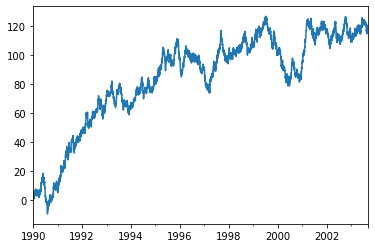

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 432x288 with 0 Axes>

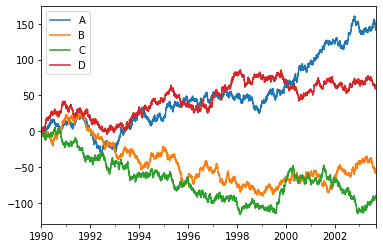

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.696766,0.633580,0.121833,0.703290
1,1990-01-02,0.207302,0.630969,0.618641,-0.740361
2,1990-01-03,-0.532826,0.717523,-0.189610,-2.104097
3,1990-01-04,0.618551,-1.274184,1.675247,-1.707649
4,1990-01-05,0.582585,-1.352941,0.432488,-0.748440
...,...,...,...,...,...
4995,2003-09-05,142.151146,-53.314163,-90.679475,63.245731
4996,2003-09-06,142.829731,-52.112070,-89.504098,63.093195
4997,2003-09-07,141.424426,-52.055148,-90.455543,62.144508
4998,2003-09-08,141.185992,-52.488129,-90.895506,61.142307


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,0.696766,0.633580,0.121833,0.703290
1990-01-02,0.207302,0.630969,0.618641,-0.740361
1990-01-03,-0.532826,0.717523,-0.189610,-2.104097
1990-01-04,0.618551,-1.274184,1.675247,-1.707649
1990-01-05,0.582585,-1.352941,0.432488,-0.748440
...,...,...,...,...
2003-09-05,142.151146,-53.314163,-90.679475,63.245731
2003-09-06,142.829731,-52.112070,-89.504098,63.093195
2003-09-07,141.424426,-52.055148,-90.455543,62.144508
2003-09-08,141.185992,-52.488129,-90.895506,61.142307


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.696766,0.633580,0.121833,0.703290
1,1990-01-02,0.207302,0.630969,0.618641,-0.740361
2,1990-01-03,-0.532826,0.717523,-0.189610,-2.104097
3,1990-01-04,0.618551,-1.274184,1.675247,-1.707649
4,1990-01-05,0.582585,-1.352941,0.432488,-0.748440
...,...,...,...,...,...
4995,2003-09-05,142.151146,-53.314163,-90.679475,63.245731
4996,2003-09-06,142.829731,-52.112070,-89.504098,63.093195
4997,2003-09-07,141.424426,-52.055148,-90.455543,62.144508
4998,2003-09-08,141.185992,-52.488129,-90.895506,61.142307


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a    0.205240
b   -0.216202
c    0.420492
d    0.307475
e   -0.038591
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0   -0.662337
1   -0.168524
2    1.550690
3   -0.059459
4   -1.278766
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

c    0.420492
d    0.307475
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [120]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [ ]:
bb[bb.columns[:9]].dtypes